In [1]:
import os
import csv
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout, SpatialDropout2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import regularizers
from keras.callbacks import ModelCheckpoint, Callback

Using TensorFlow backend.


In [2]:
def read_csv(directory):
    with open(directory + '/driving_log.csv', 'r') as csvfile:
        lines = []
        reader = csv.reader(csvfile)
        
        for i, line in enumerate(reader):
            if i != 0:
                lines.append(line)
    
        return lines
    
def load_image(source_path):
    file_dir = source_path.split('/')[-4:-1]
    filename = source_path.split('/')[-1]
    path = os.path.join(*file_dir) + '/' + filename
    image = cv2.imread(path)
    image = image[60:140, :, :] # y1:y2, x1:x2
    image = cv2.resize(image, (160, 40), interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image.astype(np.uint8)

def normalize_to_half(images):
    return images / 255.0 - 0.5

def build_generator(csv_lines, image_idx, steering_offset, batch_size):
    while True:
        X = np.zeros((0, 40, 160, 3), dtype=np.float32)
        y = np.zeros((0, 1), dtype=np.float16)

        for i in range(batch_size):
            idx = np.random.choice(len(csv_lines), 1)[0]
            line = csv_lines[idx]
            
            feature = load_image(line[image_idx])
            label = float(line[3]) + steering_offset

            X = np.append(X, feature[None,:], axis=0)
            y = np.append(y, label)
        
        X = normalize_to_half(X)

        yield shuffle(X, y)
        
def filter_bias_data(lines):
    steerings = [float(row[3]) for row in lines]

    num_bins = 100
    avg_samples_per_bin = int(math.ceil(len(steerings) / num_bins))
    hist, bins = np.histogram(steerings, num_bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.plot((np.min(steerings), np.max(steerings)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

    keep_probs = []
    target = avg_samples_per_bin * 0.5
    remove_list = []
    
    for i in range(num_bins):
        if hist[i] < target:
            keep_probs.append(1.0)
        else:
            keep_probs.append(1.0 / (hist[i] / target))

    for i in range(len(steerings)):
        for j in range(num_bins):
            if steerings[i] > bins[j] and steerings[i] <= bins[j+1]:
                if np.random.rand() > keep_probs[j]:
                    remove_list.append(i)
                    
    csv_filtered = np.delete(lines, remove_list, axis=0)
    filtered_steerings = np.delete(steerings, remove_list)

    hist, bins = np.histogram(filtered_steerings, num_bins)
    plt.bar(center, hist, align='center', width=width)
    plt.plot((np.min(filtered_steerings), np.max(filtered_steerings)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

    filtered_steerings = [float(row[3]) for row in csv_filtered]
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.hist(steerings, bins=num_bins)
    ax2.hist(filtered_steerings, bins=num_bins)
    plt.show()
    
    return csv_filtered
    
def load_data(directory):
    csv_lines = read_csv(directory)
    f, ax_list = plt.subplots(1, 3, figsize=(10, 5))
    
    for i in range(3):
        img = load_image(csv_lines[0][i])
        ax_list[i].imshow(img)
        ax_list[i].axis("off")

    plt.show()
    
    return csv_lines

def split_on_batches(train_samples, valid_samples, size=64):
    train_lines_num = len(train_samples)
    train_batches = train_lines_num // size
    train_samples_num = size * train_batches
    train_csv_lines = train_samples[:train_samples_num]
    train = train_csv_lines, train_batches
    
    valid_lines_num = len(valid_samples)
    valid_batches = valid_lines_num // size
    valid_samples_num = size * valid_batches
    valid_csv_lines = valid_samples[:valid_samples_num]
    valid = valid_csv_lines, valid_batches
    
    return train, valid, size

In [ ]:
def train_model(model_path, train, valid, batch_size, image_idx, steering_offset, epochs):
    train_csv_lines, train_batches = train
    valid_csv_lines, valid_batches = valid

    train_samples_num = len(train_csv_lines)
    train_generator = build_generator(train_csv_lines, image_idx, steering_offset, batch_size)
    valid_samples_num = len(valid_csv_lines)
    valid_generator = build_generator(valid_csv_lines, image_idx, steering_offset, batch_size)

    model = Sequential()
        
    model.add(Conv2D(24, 5, 5, input_shape=(40, 160, 3)))
    model.add(ELU())
        
    model.add(Conv2D(36, 5, 5))
    model.add(ELU())
        
    model.add(Conv2D(48, 5, 5))
    model.add(ELU())
    
    model.add(Conv2D(64, 3, 3))
    model.add(ELU())
    
    model.add(Conv2D(64, 3, 3))
    model.add(ELU())
        
    model.add(Flatten())
        
    model.add(Dense(100))
    model.add(ELU())
        
    model.add(Dense(50))
    model.add(ELU())
        
    model.add(Dense(10))
    model.add(ELU())
        
    model.add(Dense(1))
    
    optimizer = Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=optimizer)
    
    checkpoint = ModelCheckpoint('model/model{epoch:02d}.h5')
    history = model.fit_generator(train_generator, samples_per_epoch=train_samples_num, validation_data=valid_generator, nb_val_samples=valid_samples_num, nb_epoch=epochs, verbose=1, callbacks=[checkpoint])
    print(history.history)
    
    model.save_weights(model_path + ".h5")
    model_json = model.to_json()
    with open(model_path + ".json", "w") as json_file:
        json_file.write(model_json)

    print(model.summary())

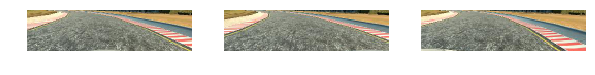

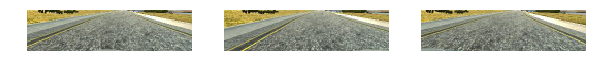

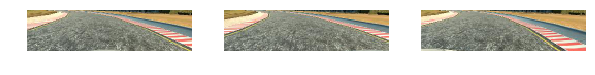

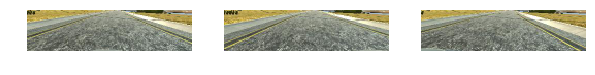

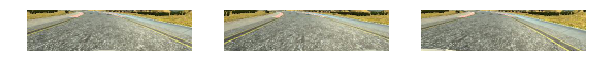

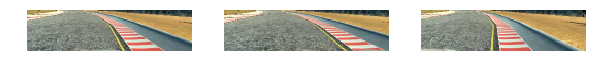

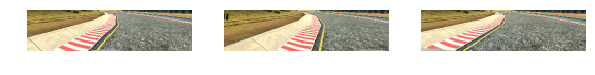

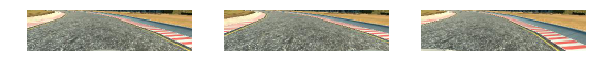

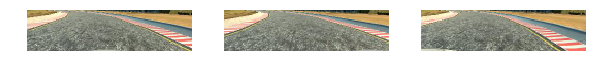

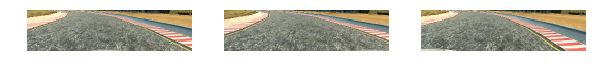

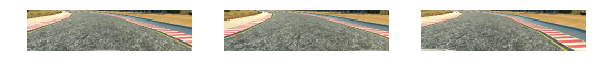

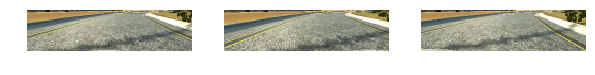

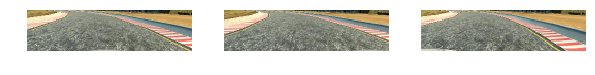

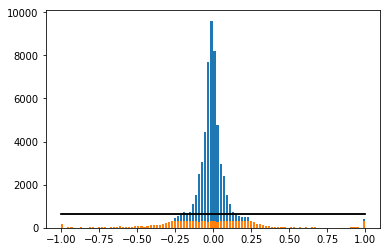

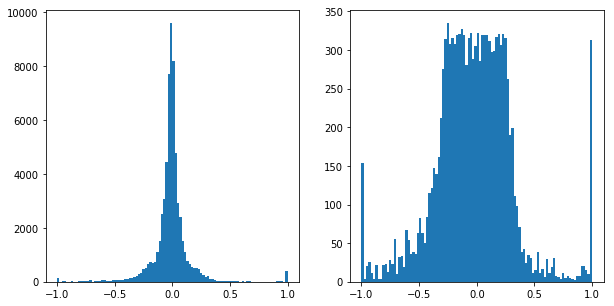

Epoch 1/1
 2688/44032 [>.............................] - ETA: 8506s - loss: 0.2120

In [ ]:
csv_lines = []
directories = ["Track1.1", "Track1.2", "Track1.3", "Track1.4", "Track1.5", "Track1.6", "Track1.7 - left border", "Track1.8 - borders", "Track1.9 - full", "Track1.9.1 - full", "Track1.9.2 - full", "Track1.9.3 - full", "Track1.9.4 - full"]
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for directory in directories:
    directory = "data/" + directory
    lines = load_data(directory)
    csv_lines = csv_lines + lines

filtered_lines = filter_bias_data(csv_lines)

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.3)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model("model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=1)
    
print("We're done")